In [1]:
!pip install chess

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 148 kB 19.9 MB/s 


In [2]:
import chess 
import torch
from torch import nn
import numpy as np
import tqdm
import random
import matplotlib.pyplot as plt

# Plotting

In [3]:
def plot_curves(arr_list, legend_list, color_list, ylabel, fig_title):
    """
    Args:
        arr_list (list): list of results arrays to plot
        legend_list (list): list of legends corresponding to each result array
        color_list (list): list of color corresponding to each result array
        ylabel (string): label of the Y axis

        Note that, make sure the elements in the arr_list, legend_list and color_list are associated with each other correctly.
        Do not forget to change the ylabel for different plots.
    """
    # set the figure type
    fig, ax = plt.subplots(figsize=(12, 8))

    # PLEASE NOTE: Change the labels for different plots
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Time Steps")

    # ploth results
    h_list = []
    for arr, legend, color in zip(arr_list, legend_list, color_list):
        # compute the standard error
        arr_err = arr.std(axis=0) / np.sqrt(arr.shape[0])
        # plot the mean
        h, = ax.plot(range(arr.shape[1]), arr.mean(axis=0), color=color, label=legend)
        # plot the confidence band
        arr_err *= 1.96
        ax.fill_between(range(arr.shape[1]), arr.mean(axis=0) - arr_err, arr.mean(axis=0) + arr_err, alpha=0.3,
                        color=color)
        # save the plot handle
        h_list.append(h)

    # plot legends
    ax.set_title(f"{fig_title}")
    ax.legend(handles=h_list)

    plt.show()

# Net

In [4]:
from torch.nn.modules.activation import ReLU
class net(nn.Module):
    def __init__(self):
      super(net, self).__init__()

      self.layers = nn.Sequential(
          nn.Linear(448, 750),
          nn.ReLU(),
          nn.Linear(750, 1000),
          nn.ReLU(),
          nn.Linear(1000, 1500),
          nn.ReLU(),
          nn.Linear(1500, 1968))

    def forward(self, x):      
      x = x.view(-1, 448)
      y = self.layers(x)
      return y

# Replay Buffer

In [5]:
class ReplayBuffer(object):
    """ Implement the Replay Buffer as a class, which contains:
            - self._data_buffer (list): a list variable to store all transition tuples.
            - add: a function to add new transition tuple into the buffer
            - sample_batch: a function to sample a batch training data from the Replay Buffer
    """
    def __init__(self, buffer_size):
        """Args:
               buffer_size (int): size of the replay buffer
        """
        # total size of the replay buffer
        self.total_size = buffer_size

        # create a list to store the transitions
        self._data_buffer = []
        self._next_idx = 0

    def __len__(self):
        return len(self._data_buffer)

    def add(self, state, act, reward, next_state, next_actions, done):
        # create a tuple
        trans = (state, act, reward, next_state, next_actions, done)

        # interesting implementation
        if self._next_idx >= len(self._data_buffer):
            self._data_buffer.append(trans)
        else:
            self._data_buffer[self._next_idx] = trans

        # increase the index
        self._next_idx = (self._next_idx + 1) % self.total_size

    def _encode_sample(self, indices):
        """ Function to fetch the state, action, reward, next state, and done arrays.
        
            Args:
                indices (list): list contains the index of all sampled transition tuples.
        """
        # lists for transitions
        state_list, actions_list, rewards_list, next_state_list, next_actions_list, dones_list = [], [], [], [], [], []

        # collect the data
        for idx in indices:
            # get the single transition
            data = self._data_buffer[idx]
            state, act, reward, next_state, next_action, d = data
            # store to the list
            state_list.append(np.array(state, copy=False))
            actions_list.append(np.array(act, copy=False))
            rewards_list.append(np.array(reward, copy=False))
            next_state_list.append(np.array(next_state, copy=False))
            next_actions_list.append(np.array(next_action, copy=False))
            dones_list.append(np.array(d, copy=False))
        # return the sampled batch data as numpy arrays
        return np.array(state_list), np.array(actions_list), np.array(rewards_list), np.array(next_state_list), np.array(next_actions_list, dtype=object), np.array(
            dones_list)

    def sample_batch(self, batch_size):
        """ Args:
                batch_size (int): size of the sampled batch data.
        """
        # sample indices with replaced
        indices = [np.random.randint(0, len(self._data_buffer)) for _ in range(batch_size)]
        return self._encode_sample(indices)

# Schedule

In [6]:
class LinearSchedule(object):
    """ This schedule returns the value linearly"""
    def __init__(self, start_value, end_value, duration):
        # start value
        self._start_value = start_value
        # end value
        self._end_value = end_value
        # time steps that value changes from the start value to the end value
        self._duration = duration
        # difference between the start value and the end value
        schedule_amount = end_value - start_value
        # amount it changed per timestep
        self._delta = schedule_amount / duration

    def get_value(self, time):
        # logic: if time > duration, use the end value, else use the scheduled value
        """ eturn the epsilon for each time step within the duration.
        """
        if time > self._duration:
          return self._end_value
        return self._start_value + (self._delta * time)

# Agent

In [11]:
class DQNAgent(object):
    # initialize the agent
    def __init__(self, params):
      # save the parameters
      self.params = params

      # create value network
      self.behavior_policy_net = net()
      # create target network
      self.target_policy_net = net()

      # initialize target network with behavior network
      self.target_policy_net.load_state_dict(self.behavior_policy_net.state_dict())

      # send the agent to a specific device: cpu or gpu
      # TODO: GPU
      self.device = torch.device("cuda")
      self.behavior_policy_net.to(self.device)
      self.target_policy_net.to(self.device)

      # optimizer
      self.optimizer = torch.optim.Adam(self.behavior_policy_net.parameters(), lr=params['learning_rate'])

    # get action
    def get_action(self, state, legal_moves, eps):
      if np.random.random() < eps:  # with probability eps, the agent selects a random action
        action = np.random.choice(legal_moves, 1)[0]
        return action
      else:  # with probability 1 - eps, the agent selects a greedy policy
        state = self._arr_to_tensor(state)
        with torch.no_grad():
          q_values = self.behavior_policy_net(state)[0]
          # TODO: is gather faster
          legal_q_values = np.array([q_values.cpu()[move] for move in legal_moves])
          is_curr_player_white = (state[6, 0, 0]).cpu().numpy()
          legal_q_values *= is_curr_player_white
          action_id = legal_q_values.argmax()
        return legal_moves[action_id]

    # update behavior policy
    def update_behavior_policy(self, batch_data):
      # convert batch data to tensor and put them on device
      batch_data_tensor = self._batch_to_tensor(batch_data)

      # get the transition data
      state_tensor = batch_data_tensor['state']
      actions_tensor = batch_data_tensor['action'] # actions are idxs here
      next_state_tensor = batch_data_tensor['next_state']
      next_state_actions_tensor = batch_data_tensor['next_state_actions']
      rewards_tensor = batch_data_tensor['reward']
      dones_tensor = batch_data_tensor['done'] # 1 for done, 0 for not done

      # compute the q value estimation using the behavior network
      q_vals = self.behavior_policy_net(state_tensor).gather(1, actions_tensor)

      # compute the TD target using the target network
      with torch.no_grad():
        target_vals = self.target_policy_net(next_state_tensor).detach()

      # minimax => val * (-1 if black or 1 if white)
      max_vals = []
      for i, actions_tensor in enumerate(next_state_actions_tensor):
        if not dones_tensor[i].item():
          temp_target_vals = torch.index_select(target_vals[i], 0, actions_tensor)
          is_curr_player_white = state_tensor[i, 6, 0, 0]
          temp_target_vals *= is_curr_player_white

          max_vals.append(temp_target_vals.max())
        else:
          # append dummy value to keep lengths correct
          max_vals.append(0)
      
      target_vals = torch.tensor(max_vals).view(len(max_vals), 1).to(self.device)

      # Gamma is 1 for this task
      # target is 0 when in terminal state
      targets = rewards_tensor + target_vals

      # compute the loss
      criterion = nn.MSELoss()
      loss = criterion(q_vals, targets)

      # minimize the loss
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

      return loss.item()

    # update update target policy
    def update_target_policy(self):
      # hard update
      self.target_policy_net.load_state_dict(self.behavior_policy_net.state_dict())

    # auxiliary functions
    def _arr_to_tensor(self, arr):
      arr = np.array(arr)
      arr_tensor = torch.from_numpy(arr).float().to(self.device)
      return arr_tensor

    def _batch_to_tensor(self, batch_data):
      # store the tensor
      batch_data_tensor = {'state': [], 'action': [], 'reward': [], 'next_state': [], 'next_state_actions': [], 'done': []}
      # get the numpy arrays
      state_arr, action_arr, reward_arr, next_state_arr, next_state_actions_arr, done_arr = batch_data
      # convert to tensors
      batch_data_tensor['state'] = torch.tensor(state_arr, dtype=torch.float32).to(self.device)
      batch_data_tensor['action'] = torch.tensor(action_arr).long().view(-1, 1).to(self.device)
      batch_data_tensor['reward'] = torch.tensor(reward_arr, dtype=torch.float32).view(-1, 1).to(self.device)
      batch_data_tensor['next_state'] = torch.tensor(next_state_arr, dtype=torch.float32).to(self.device)
      tensor_list = []
      for actions in next_state_actions_arr:
        temp_tensor = torch.tensor(actions, dtype=torch.int32).to(self.device)
        tensor_list.append(temp_tensor)
      batch_data_tensor['next_state_actions'] = torch.nested.nested_tensor(tensor_list, dtype=torch.int32).to(self.device)
      batch_data_tensor['done'] = torch.tensor(done_arr, dtype=torch.float32).view(-1, 1).to(self.device)

      return batch_data_tensor

# ENV

In [24]:
class ChessENV():

  def __init__(self):
    self.board = chess.Board()

    self.id_to_action, self.action_to_id = self._create_action_space()

  def step(self, action):
    move = self.id_to_action[action]
    is_curr_player_white = self.board.turn
    reward = 0

    # INTERMEDIARY REWARDS: Used to speed up learning
    # Total 39 intermediary rewards for taking all pieces (no promotions)
    rewards_arr = [1, 3, 3, 5, 9]
    captured_piece = self.board.piece_type_at(move.to_square)
    if captured_piece:
      reward += rewards_arr[captured_piece - 1]

    self.board.push(move)

    outcome = self.board.outcome() # None if unterminated
    terminated = 0
    if outcome:
      terminated = 1
      winner = outcome.termination == chess.Termination.CHECKMATE
      # Only the moving player can on a turn
      if winner:
        reward = 50
      else:
        # No reward for draw
        # TODO: Consider what would occur with negative reward for draw
        # Messes with minmiax (or does it?)
        reward = 0

    # Black attempts to minimze => give negative reward
    if not is_curr_player_white:
      reward *= -1

    next_state = self._board_to_state()

    # The actions available in the next state
    next_legal_moves = self._legal_moves()

    return next_state, reward, next_legal_moves, terminated

  def reset(self):
    self.board.reset()

    return self._board_to_state(), self._legal_moves()

  def get_outcome(self):
    outcome = self.board.outcome()
    game_won = outcome.termination == chess.Termination.CHECKMATE
    winner = outcome.winner
    return game_won, winner

  # Returns the ids of the legal moves in this state
  def _legal_moves(self):
    return [self.action_to_id[move] for move in self.board.legal_moves]

  # piece_array = ['pawn', 'knight', 'bishop', 'rook', 'queen', 'king']
  def _board_to_state(self):
    state = np.zeros([7, 8, 8])
    for square in range(64):
      r = int(square / 8)
      c = square % 8
      piece = self.board.piece_at(square)
      # None when empty
      if piece:
        if piece.color:
          val = 1
        else:
          val = -1
        state[piece.piece_type - 1, r, c] = val
    # TODO: Do i want to include draw possibility information
    # Halfmove is easy
    # repetitions is slow to check
    turn = self.board.turn
    if turn:
      turn = 1
    else:
      turn = 0
    state[6, 0, 0] = turn # encoded as -1 = Black, 1 = White
    state[6, 0, 1] = self.board.halfmove_clock
    if self.board.is_repetition(4):
      state[6, 0, 2] = 1
    return state

  def _create_action_space(self):
    action_space = []
    b = chess.Board.empty()
    for square in range(64):
        # Place queen and see where it attacks
        b.set_piece_at(square, chess.Piece.from_symbol('Q'))
        q_moves = b.legal_moves
        action_space.extend(list(q_moves))

        # Place knight and see where it attacks
        b.set_piece_at(square, chess.Piece.from_symbol('N'))
        n_moves = b.legal_moves
        action_space.extend(list(n_moves))

        b.remove_piece_at(square)

    # Count underpromotions manually:
    # 8 forward promotions, 7 right-capture promotions, 7 left-capture promotions
    # which can all promote to 4 pieces for 2 colors
    # Queen promotions could be considered the same as a normal queen move (identical end state)
    # However, the library models queen promotions seperately
    for square in range(48, 56):
      b.set_piece_at(square, chess.Piece.from_symbol('P'))
      moves = list(b.legal_moves)
      action_space.extend(moves)

      if not square == 48:
        left_capture_square = square + 7
        b.set_piece_at(left_capture_square, chess.Piece.from_symbol('p'))
        # TODO: not setting pieces
        moves = list(b.legal_moves)[:4]
        action_space.extend(moves)
        b.remove_piece_at(left_capture_square)

      if not square == 55:
        right_capture_square = square + 9
        b.set_piece_at(right_capture_square, chess.Piece.from_symbol('p'))
        moves = list(b.legal_moves)[:4]
        action_space.extend(moves)
        b.remove_piece_at(right_capture_square)

      b.remove_piece_at(square)

    b.turn = chess.BLACK
    for square in range(8, 16):
      b.set_piece_at(square, chess.Piece.from_symbol('p'))
      moves = list(b.legal_moves)
      action_space.extend(moves)

      if not square == 8:
        left_capture_square = square - 9
        b.set_piece_at(left_capture_square, chess.Piece.from_symbol('P'))
        moves = list(b.legal_moves)[:4]
        action_space.extend(moves)
        b.remove_piece_at(left_capture_square)

      if not square == 15:
        right_capture_square = square - 7
        b.set_piece_at(right_capture_square, chess.Piece.from_symbol('P'))
        moves = list(b.legal_moves)[:4]
        action_space.extend(moves)
        b.remove_piece_at(right_capture_square)

      b.remove_piece_at(square)

    id_to_action = {i : move for i, move in enumerate(action_space)}
    action_to_id = {move : i for i, move in enumerate(action_space)}

    return id_to_action, action_to_id

# Training Loop

In [25]:
def train_dqn_agent(env, params):
    # create the DQN agent
    my_agent = DQNAgent(params)

    # create the epsilon-greedy schedule
    my_schedule = LinearSchedule(start_value=params['epsilon_start_value'],
                                 end_value=params['epsilon_end_value'],
                                 duration=params['epsilon_duration'])

    # create the replay buffer
    replay_buffer = ReplayBuffer(params['replay_buffer_size'])

    # training variables
    episode_t = 0
    rewards = []
    train_returns = []
    train_loss = []
    outcomes = [0, 0, 0] # white_wins, black_wins, draws
    loss = 0

    # reset the environment
    state, legal_actions = env.reset()

    # start training
    pbar = tqdm.trange(params['total_training_time_step'])
    smallest_return = 0 # save the model that was best as black
    biggest_return = 0 # save the model that was best as white
    for t in pbar:
        # scheduled epsilon at time step t
        eps_t = my_schedule.get_value(t)
        # get one epsilon-greedy action
        action = my_agent.get_action(state, legal_actions, eps_t)

        # step in the environment
        next_state, reward, next_legal_actions, done = env.step(action)

        # add to the buffer
        replay_buffer.add(state, action, reward, next_state, next_legal_actions, done)
        rewards.append(reward)

        # check termination
        if done:
            game_won, winner = env.get_outcome()
            if game_won:
              if winner:
                outcomes[0] = outcomes[0] + 1
              else:
                outcomes[1] = outcomes[1] + 1
            else:
              outcomes[2] = outcomes[2] + 1

            # compute the return
            G = 0
            for r in reversed(rewards):
              # Undiscounted => gamma = 1
              G = r + G

            if G > biggest_return:
              torch.save(my_agent.behavior_policy_net.state_dict(), f"./{params['model_name']}_white")
              biggest_return = G
            if G < smallest_return:
              torch.save(my_agent.behavior_policy_net.state_dict(), f"./{params['model_name']}_black")
              smallest_return = G

            # store the return
            train_returns.append(G)
            episode_idx = len(train_returns)

            # print the information
            pbar.set_description(
                f"Ep={episode_idx} | "
                f"G={np.mean(train_returns[-10:]) if train_returns else 0:.2f} | "
                f"Eps={eps_t}"
            )

            # reset the environment
            episode_t, rewards = 0, []
            state, legal_actions = env.reset()
        else:
            # increment
            state = next_state
            legal_actions = next_legal_actions
            episode_t += 1

        if t > params['start_training_step']:
            # update the behavior model
            if not np.mod(t, params['freq_update_behavior_policy']):
                """
                  Update the behavior policy network
                """
                batch_data = replay_buffer.sample_batch(params['batch_size'])
                loss = my_agent.update_behavior_policy(batch_data)
                train_loss.append(loss)

            # update the target model
            if not np.mod(t, params['freq_update_target_policy']):
                """
                  Update the behavior policy network
                """
                my_agent.update_target_policy()

    # save the results
    torch.save(my_agent.behavior_policy_net.state_dict(), f"./{params['model_name']}_final")
    return train_returns, train_loss, outcomes

# Run Experiment

In [26]:
if __name__ == '__main__':
    # set the random seed
    np.random.seed(1234)
    random.seed(1234)
    torch.manual_seed(1234)

    # create environment
    my_env = ChessENV()

    # create training parameters
    train_parameters = {
        'total_training_time_step': 500_000,

        'epsilon_start_value': 1.0,
        'epsilon_end_value': 0.01,
        'epsilon_duration': 250_000,

        'replay_buffer_size': 50000,
        'start_training_step': 2000,
        'freq_update_behavior_policy': 4,
        'freq_update_target_policy': 2000,

        'batch_size': 32,
        'learning_rate': 1e-3,

        'model_name': "chess.pt"
    }

    # create experiment
    train_returns, train_loss, outcomes = train_dqn_agent(my_env, train_parameters)

Ep=3910 | G=-0.20 | Eps=0.01: 100%|██████████| 500000/500000 [27:31<00:00, 302.79it/s]


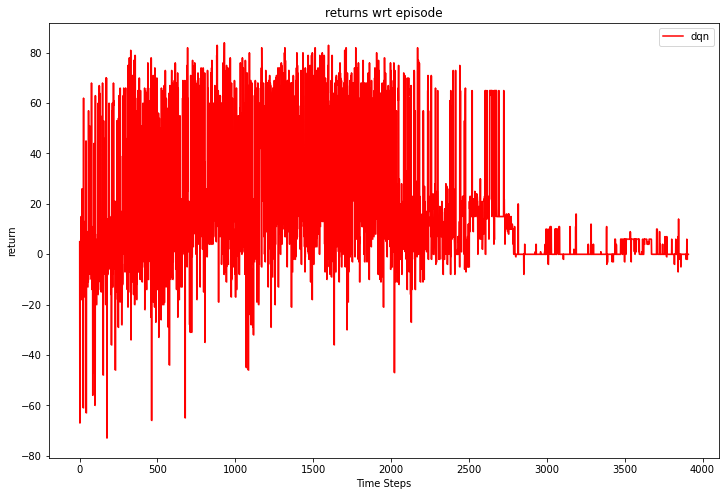

In [27]:
plot_curves([np.array([train_returns])], ['dqn'], ['r'], 'return', 'returns wrt episode')

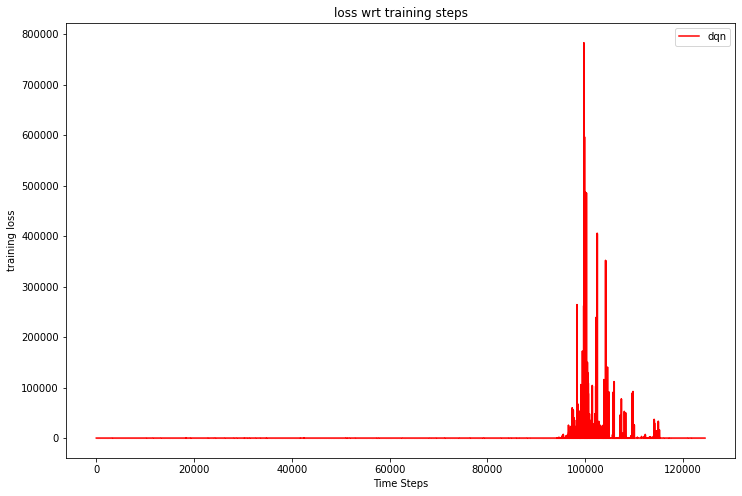

In [28]:
plot_curves([np.array([train_loss])], ['dqn'], ['r'], 'training loss', 'loss wrt training steps')

In [29]:
print(outcomes)

[796, 16, 3098]


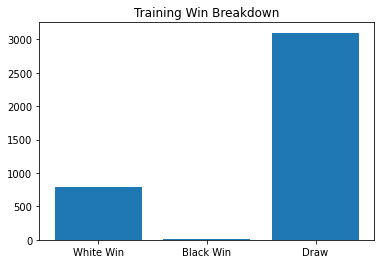

In [30]:
plt.bar([0, 1, 2], outcomes)
my_xticks = ['White Win','Black Win','Draw']
plt.title('Training Win Breakdown')
plt.xticks([0, 1, 2], my_xticks)
plt.show()

# Trained Agent

In [31]:
class TrainedAgent():

  def __init__(self, two_paths=None, single_path=None):
    self.env = ChessENV()

    if two_paths:
      white_model = net()
      white_model.load_state_dict(torch.load(two_paths[0]))
      white_model.eval()
      self.white_model = white_model

      black_model = net()
      black_model.load_state_dict(torch.load(two_paths[1]))
      black_model.eval()
      self.black_model = black_model
    else:
      model = net()
      model.load_state_dict(torch.load(single_path))
      model.eval()
      self.white_model = model
      self.black_model = model
  
  def rollout_self_play(self):
    state, legal_moves = self.env.reset()

    done = False

    while not done:
      action = self.choose_move(state, legal_moves)

      state, _, legal_moves, done = self.env.step(action)
    
    return self.env.board.move_stack
  
  def choose_move(self, state, legal_moves):
    is_curr_player_white = state[6, 0, 0]
    if is_curr_player_white:
      net = self.white_model
    else:
      net = self.black_model

    arr = np.array(state)
    state = torch.from_numpy(state).float()

    with torch.no_grad():
      q_values = net(state)[0]
      legal_q_values = np.array([q_values.cpu()[move] for move in legal_moves])
      legal_q_values *= is_curr_player_white
      action_id = legal_q_values.argmax()
    return legal_moves[action_id]

In [32]:
agent = TrainedAgent(two_paths=['chess.pt_white', 'chess.pt_black'])
moves = agent.rollout_self_play()
b = chess.Board()
print(b)
for move in moves:
  print('------------------------------')
  print(move)
  b.push(move)
  print(b)
print(b.outcome())
print(len(moves))

r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R
------------------------------
c2c4
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . P . . . . .
. . . . . . . .
P P . P P P P P
R N B Q K B N R
------------------------------
g8h6
r n b q k b . r
p p p p p p p p
. . . . . . . n
. . . . . . . .
. . P . . . . .
. . . . . . . .
P P . P P P P P
R N B Q K B N R
------------------------------
c4c5
r n b q k b . r
p p p p p p p p
. . . . . . . n
. . P . . . . .
. . . . . . . .
. . . . . . . .
P P . P P P P P
R N B Q K B N R
------------------------------
h8g8
r n b q k b r .
p p p p p p p p
. . . . . . . n
. . P . . . . .
. . . . . . . .
. . . . . . . .
P P . P P P P P
R N B Q K B N R
------------------------------
b1c3
r n b q k b r .
p p p p p p p p
. . . . . . . n
. . P . . . . .
. . . . . . . .
. . N . . . . .
P P . P P P P P
R . B Q K B N R
------------------------------
g8h8
r n b q k b . r


In [36]:
agent = TrainedAgent(single_path='chess.pt_white')
moves = agent.rollout_self_play()
b = chess.Board()
print(b)
for move in moves:
  print('------------------------------')
  print(move)
  b.push(move)
  print(b)
print(b.outcome())
print(len(moves))

r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R
------------------------------
c2c4
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . P . . . . .
. . . . . . . .
P P . P P P P P
R N B Q K B N R
------------------------------
g8h6
r n b q k b . r
p p p p p p p p
. . . . . . . n
. . . . . . . .
. . P . . . . .
. . . . . . . .
P P . P P P P P
R N B Q K B N R
------------------------------
c4c5
r n b q k b . r
p p p p p p p p
. . . . . . . n
. . P . . . . .
. . . . . . . .
. . . . . . . .
P P . P P P P P
R N B Q K B N R
------------------------------
h8g8
r n b q k b r .
p p p p p p p p
. . . . . . . n
. . P . . . . .
. . . . . . . .
. . . . . . . .
P P . P P P P P
R N B Q K B N R
------------------------------
b1c3
r n b q k b r .
p p p p p p p p
. . . . . . . n
. . P . . . . .
. . . . . . . .
. . N . . . . .
P P . P P P P P
R . B Q K B N R
------------------------------
g8h8
r n b q k b . r


In [37]:
agent = TrainedAgent(single_path='chess.pt_black')
moves = agent.rollout_self_play()
b = chess.Board()
print(b)
for move in moves:
  print('------------------------------')
  print(move)
  b.push(move)
  print(b)
print(b.outcome())
print(len(moves))

r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R
------------------------------
c2c4
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . P . . . . .
. . . . . . . .
P P . P P P P P
R N B Q K B N R
------------------------------
g8h6
r n b q k b . r
p p p p p p p p
. . . . . . . n
. . . . . . . .
. . P . . . . .
. . . . . . . .
P P . P P P P P
R N B Q K B N R
------------------------------
d1c2
r n b q k b . r
p p p p p p p p
. . . . . . . n
. . . . . . . .
. . P . . . . .
. . . . . . . .
P P Q P P P P P
R N B . K B N R
------------------------------
h8g8
r n b q k b r .
p p p p p p p p
. . . . . . . n
. . . . . . . .
. . P . . . . .
. . . . . . . .
P P Q P P P P P
R N B . K B N R
------------------------------
c2g6
r n b q k b r .
p p p p p p p p
. . . . . . Q n
. . . . . . . .
. . P . . . . .
. . . . . . . .
P P . P P P P P
R N B . K B N R
------------------------------
g8h8
r n b q k b . r


In [38]:
agent = TrainedAgent(single_path='chess.pt_final')
moves = agent.rollout_self_play()
b = chess.Board()
print(b)
for move in moves:
  print('------------------------------')
  print(move)
  b.push(move)
  print(b)
print(b.outcome())
print(len(moves))

r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R
------------------------------
f2f3
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . P . .
P P P P P . P P
R N B Q K B N R
------------------------------
g8h6
r n b q k b . r
p p p p p p p p
. . . . . . . n
. . . . . . . .
. . . . . . . .
. . . . . P . .
P P P P P . P P
R N B Q K B N R
------------------------------
e1f2
r n b q k b . r
p p p p p p p p
. . . . . . . n
. . . . . . . .
. . . . . . . .
. . . . . P . .
P P P P P K P P
R N B Q . B N R
------------------------------
h8g8
r n b q k b r .
p p p p p p p p
. . . . . . . n
. . . . . . . .
. . . . . . . .
. . . . . P . .
P P P P P K P P
R N B Q . B N R
------------------------------
d1e1
r n b q k b r .
p p p p p p p p
. . . . . . . n
. . . . . . . .
. . . . . . . .
. . . . . P . .
P P P P P K P P
R N B . Q B N R
------------------------------
g8h8
r n b q k b . r
